In [5]:
import pybgpstream

# Get data
stream = pybgpstream.BGPStream(
   from_time="2017-07-07 00:00:00", until_time="2017-07-07 00:00:30 UTC",
   collectors=["route-views.sg", "route-views.eqix"],
   record_type="updates"
)
stream.set_data_interface_option("broker", "cache-dir", "/home/mgumilang/.cache/")

In [6]:
# "Train" the code by building the global view of the network
import networkx as nx
import operator
from itertools import groupby
from collections import Counter

# init graph
as_graph = nx.Graph()

# init prefix dictionary
adr_dict = {}

for rec in stream.records():
    for elem in rec:
        # If element type == W, then remove the AS that announced it
        # else add AS path to graph
        if elem.type == 'W':
            pass
            # # Get origin adress to get the ASN
            # pfx = elem.fields['prefix']
            # origin_adr,mask = pfx.split('/')
            # # Remove if ASN in dictionary, else ignore
            # if origin_adr in adr_dict:
            #     asn = adr_dict[origin_adr]['asn']
            #     if asn != -1:
            #         as_graph.remove_node(asn)
        else:
            # Get the peer ASn and address
            peer = str(elem.peer_asn)
            peer_adr = str(elem.peer_address)
            # Get the array of ASns in the AS path and remove repeatedly prepended ASns
            hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]

            if len(hops) > 1 and hops[0] == peer:
                # Get the origin ASn and its prefix
                origin = hops[-1]
                pfx = elem.fields['prefix']
                # Add new edges to the NetworkX graph
                for i in range(0,len(hops)-1):
                    # Add nodes
                    # if not as_graph.has_node(hops[i]):
                    #     as_graph.add_node(hops[i], prefix=Counter())
                    # if not as_graph.has_node(hops[i+1]):
                    #     as_graph.add_node(hops[i+1], prefix=Counter())
                    
                    # If edge in graph
                    if as_graph.has_edge(hops[i],hops[i+1]):
                        # Cap weight at 10
                        if as_graph[hops[i]][hops[i+1]]['weight'] < 10:
                            as_graph[hops[i]][hops[i+1]]['weight'] += 0.01
                    else:
                        # create new edge w/ 0 weight if not
                        as_graph.add_edge(hops[i],hops[i+1],weight=0.01)
                
                # Update prefix dictionary
                ## From peer
                if peer_adr not in adr_dict:
                    adr_dict[peer_adr] = {'counter': Counter(), 'asn': -1}
                adr_dict[peer_adr]['counter'].update([peer])

                # adr_dict[peer_adr]['asn'] = max(adr_dict[peer_adr]['counter'].items(), key=operator.itemgetter(1))[0]

                ## From origin
                origin_adr,mask = pfx.split('/')
                if origin_adr not in adr_dict:
                    adr_dict[origin_adr] = {'counter': Counter(), 'asn': -1}
                adr_dict[origin_adr]['counter'].update([origin])

                # adr_dict[origin_adr]['asn'] = max(adr_dict[origin_adr]['counter'].items(), key=operator.itemgetter(1))[0]

                # Update prefix to origin node
                # as_graph.nodes[origin]['prefix'].update([pfx])

# Update true asn for each prefix in dictionary
# Max count in 'counter' = true asn
for k in adr_dict:
    adr_dict[k]['asn'] = max(adr_dict[k]['counter'].items(), key=operator.itemgetter(1))[0]

# Get edges and weights to draw graph
edges = as_graph.edges
weights = [as_graph[u][v]['weight'] for u,v in edges]

In [14]:
for k in adr_dict:
    print((k,adr_dict[k]))

('91.192.240.0', {'counter': Counter({'31560': 7}), 'asn': '31560'})
('2804:2478::', {'counter': Counter({'264224': 18}), 'asn': '264224'})
('2804:14c:da86::', {'counter': Counter({'28573': 12}), 'asn': '28573'})
('2a03:90c0:c0::', {'counter': Counter({'199524': 9}), 'asn': '199524'})
('2001:df2:c000::', {'counter': Counter({'132644': 18}), 'asn': '132644'})
('193.0.132.0', {'counter': Counter({'3203': 23}), 'asn': '3203'})
('171.18.20.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.14.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.10.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.46.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.21.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.13.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.22.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.12.0', {'counter': Counter({'12696': 1}), 'asn': '12696'})
('171.18.45.0', {'counter': 

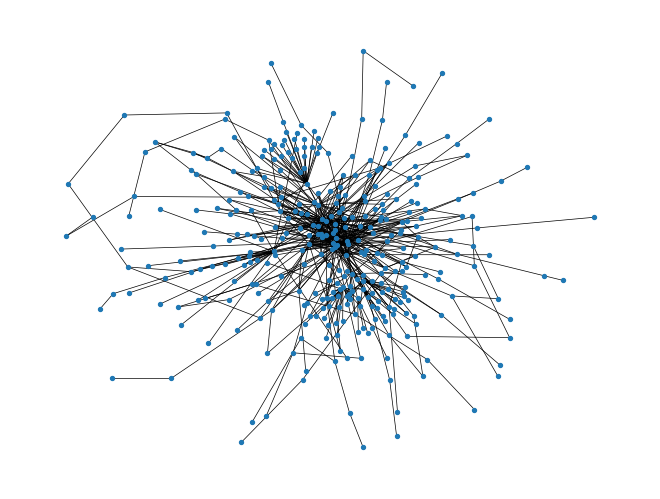

In [7]:
# Draw initial graph
nx.draw(as_graph, width=0.5, node_size=8)

In [10]:
# Use stream data after the time taken to build graph to demonstrate detecting hijacks
# Create function to check if AS path is path in graph
def check_path(G, as_path):
    # G: AS graph
    # as path: list of int
    # list of asn nodes that are potentially in graph
    # return true if as_path is in graph, false otherwis
    for i in range(len(as_path)-1):
        if not G.has_edge(as_path[i],as_path[i+1]):
            return False
    return True

In [6]:
# Implement MoAS detector
def check_moas(as_dict, pfx, asn):
    # Check if address is truly belong to the asn
    # as_dict: dictionary of address and the asn they belong too
    # pfx: string of address/mask ('111.111.111.111/22')
    # asn: int
    adr,mask = pfx.split('/')
    return as_dict[adr]['asn'] == asn

# for rec in stream.records():
#     for elem in rec:
#         if elem.type == 'W':
#             continue
#         # Get the prefix
#         pfx = elem.fields["prefix"]
#         # Get the list of ASes in the AS path
#         ases = elem.fields["as-path"].split(" ")
#         if len(ases) > 0:
#             # Get the origin ASn (rightmost)
#             origin = ases[-1]
#             # Insert the origin ASn in the set of
#             # origins for the prefix
#             prefix_origin[pfx].add(origin)

# # Print the list of MOAS prefix and their origin ASns
# for pfx in prefix_origin:
#     if len(prefix_origin[pfx]) > 1:
#         print((pfx, ",".join(prefix_origin[pfx])))

('170.51.243.0/24', '19037,11664')
('209.12.70.0/23', '395918,{395573,395918}')
('186.182.234.0/24', '19037,11664')
('205.134.205.0/24', '14517,20394')
('205.134.194.0/24', '14517,20394')
('204.194.138.0/24', '40466,11273')
('41.243.3.0/24', '327707,37020')
('2405:a700:14::/48', '9498,9583')
('2405:a700:15::/48', '9498,9583')
('198.133.158.0/23', '54054,2914')
('204.194.23.0/24', '54054,54145')
('2001:dc7:b::/48', '24151,24406')
('2001:dc7:a::/48', '24151,24406')
('2001::/32', '1101,6939,25192')
('76.10.211.0/24', '11013,29803')
('91.240.176.0/24', '41489,20712')
('91.240.229.0/24', '41489,20712')
('2a00:1560:f::/48', '64661,29684')
('2001:428::/32', '209,3910')
('2001:428:f000::/36', '3908,209')
('200.80.244.0/24', '27754,3')
('2001:5e0::/32', '16713,{395394}')
('2001:468:1202::/48', '54728,20130')
('2001:460:70::/46', '3561,7991')
('31.171.126.0/23', '199311,65456')
('2001:16a0::/29', '{25019,39891,64785,64787,64803,65000},{25019,39891}')
('1.3.33.0/24', '133741,133948')
('2600:1480:

In [10]:
# Implement sub-MoAS detector
# <prefix, origin-ASns-set > dictionary
sub_moas = defaultdict(set)

for rec in stream.records():
    for elem in rec:
        if elem.type == 'W':
            continue
        # Get the prefix
        pfx = elem.fields["prefix"]
        # Get address and subnet mask
        adr, mask = pfx.split('/')
        # Get the list of ASes in the AS path
        ases = elem.fields["as-path"].split(" ")
        if len(ases) > 0:
            # Get the origin ASn (rightmost)
            origin = ases[-1]
            # Insert the origin ASn in the set of
            # origins for the prefix
            prefix_origin[adr].add((mask,origin))

# Print the list of MOAS prefix and their origin ASns
for adr in sub_moas:
    if len(sub_moas[adr]) > 1:
        print((adr, ",".join(sub_moas[adr])))

In [ ]:
# Implement Fake Path detector

In [ ]:
# Graph for MoAS detector, sub-MoAS detector, and Fake Path detector

In [ ]:
# Implement DEFCON #16
# Implement sub-MoAS detector
# <prefix, origin-ASns-set > dictionary
# defcon = defaultdict(set)

# for rec in stream.records():
#     for elem in rec:
#         if elem.type == 'W':
#             continue
#         # Get the prefix
#         pfx = elem.fields["prefix"]
#         # Get address and subnet mask
#         adr, mask = pfx.split('/')
#         # Get the list of ASes in the AS path
#         ases = elem.fields["as-path"].split(" ")
#         if len(ases) > 0:
#             # Get the origin ASn (rightmost)
#             origin = ases[-1]
#             # Insert the origin ASn in the set of
#             # origins for the prefix
#             prefix_origin[adr].add((mask,origin))

# # Print the list of MOAS prefix and their origin ASns
# for adr in sub_moas:
#     if len(sub_moas[adr]) > 1:
#         print((adr, ",".join(sub_moas[adr])))